In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import scipy.stats as stats
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# try to match chart style
import seaborn as sns
sns.color_palette('Blues')
sns.set_style('darkgrid')

In [2]:
# turn off debug to get cleaned source data
debug = False

In [3]:
%run merge-data.ipynb

<ipython-input-3-11ba52ca5917>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['company']=df.apply(lambda x: getCompanyName(x.sponsor_collaborators, x.lead_sponsor, x.collaborators), axis=1)
<ipython-input-3-11ba52ca5917>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['symbol']=df.company.apply(lambda x: findSymbol(x, ticker_all))


In [91]:
# load saved price data
allprice=pd.read_csv('allprice.csv', index_col=0, parse_dates=True)
#allprice['Date'] = pd.to_datetime(allprice["Date"])

## Q2: Whether there is an impact when clinical trials are withdrawn/suspended

In [111]:
# temporary turn on debug when needed
#debug = True

In [6]:
# question related source data overview
if (debug):
    print('initial data shape: ', df.shape)
    print('total phases:', df['phases'].nunique(), df['phases'].unique())
    print('total status:', df['status'].nunique(), df['status'].unique())
    print('total symbols:', df['symbol'].nunique(), df['symbol'].unique())

In [113]:
# filter data to keep only relevent data points
q2=df[['symbol','company','phases', 'status','last_update_posted','completion_date', 'why_stopped']]
q2=q2.dropna(subset=['symbol','status'])

if (debug):
    print('question related data shape: ', q2.shape)
    print('total status:', q2['status'].nunique(), q2['status'].unique())

question related data shape:  (367, 7)
total status: 11 ['Recruiting' 'Active, not recruiting' 'Completed'
 'Approved for marketing' 'Enrolling by invitation' 'Terminated'
 'No longer available' 'Not yet recruiting' 'Withdrawn' 'Available'
 'Suspended']


In [120]:
#symbol performance during trail period using completion date
def getSymbolPerformance(symbol, date, offsetdays):    
#     startdate = datetime.strptime(date, "%Y-%m-%d") - timedelta(days=0) # same day
#     enddate = datetime.strptime(date, "%Y-%m-%d") + timedelta(days=5)  # 5 days after
    startdate = date - timedelta(days=offsetdays) 
    enddate = date + timedelta(days=offsetdays) 

    try:
        drange = pd.date_range(start=startdate, end=enddate)
        df = allprice[(allprice.symbol==symbol) & (allprice.index.isin(drange))]
        #df = allprice[(allprice.symbol==symbol) & (allprice.Date >= startdate) & (allprice.Date <= startdate)].sort_values('Date')    
        if (df.empty):
            return None
    except:
        return None
    
    startprice = df.iloc[0].Open
    endprice = df.tail(1).Close.values[0]
    return 100*(endprice-startprice)/startprice


In [124]:
# testing
#if debug:
    #getSymbolPerformance('ABC','2020-02-10',14)

In [125]:
# all symbol performance
q2['performance2Weeks'] = q2.apply(lambda x: getSymbolPerformance(x.symbol, min(x.completion_date, x.last_update_posted), 14), axis=1)
q2['performance7Days'] = q2.apply(lambda x: getSymbolPerformance(x.symbol, min(x.completion_date, x.last_update_posted), 7), axis=1)
q2['performance3Days'] = q2.apply(lambda x: getSymbolPerformance(x.symbol, min(x.completion_date, x.last_update_posted), 3), axis=1)
q2['performanceSameDay'] = q2.apply(lambda x: getSymbolPerformance(x.symbol, min(x.completion_date, x.last_update_posted), 0), axis=1)
# default to 2 weeks
q2['performance'] = q2['performance2Weeks']


In [128]:
if (debug):
    print(q2[pd.isna(q2.performance)])
    

     symbol                          company           phases  \
214    GILD                  Gilead Sciences              NaN   
390     NVS         Novartis Pharmaceuticals              NaN   
404    CAPR                        Capricor               NaN   
761    ALXN          Alexion Pharmaceuticals              NaN   
773    INCY                          Incyte               NaN   
835    BLPH                      Bellerophon              NaN   
955    LBPS                    4D pharma plc          Phase 2   
1037   MESO                  Mesoblast  Sàrl              NaN   
2467   MESO                  Mesoblast  Sàrl              NaN   
2497   ANGN                Angion Biomedica           Phase 2   
2682    NVS         Novartis Pharmaceuticals              NaN   
3113   GLBL                       Cartesian   Phase 1|Phase 2   
3695   CFRX                       ContraFect              NaN   
3731    LLY                   Eli Lilly and               NaN   
3842   REGN        Regene

In [129]:
#q2 = q2.dropna(subset=['symbol','performance2Weeks','performance7Days','performanceSameDay']).sort_values('performance')
q2 = q2.dropna(subset=['symbol','performance']).sort_values('performance')

In [133]:
if (debug):
    print(q2[pd.isna(q2.performance2Weeks) | pd.isna(q2.performance7Days)| pd.isna(q2.performanceSameDay)])

     symbol                                            company  \
4897   GRTS                                         Gritstone    
3162   PHAR                                          Pharming    
927     NVS                   Novartis Pharmaceuticals|Incyte    
4055   BNTX  BioNTech SE|Shanghai Fosun Pharmaceutical Deve...   
4550   RDHL                                   RedHill  Limited   
767    KPTI                                    Karyopharm  Inc   
4545    AZN                                        AstraZeneca   
927    INCY                   Novartis Pharmaceuticals|Incyte    
3336   KMDA                                             Kamada   
5167   INSM                                            Insmed    
4404    LLY                                     Eli Lilly and    
1248    GSK                                    GlaxoSmithKline   
1734   HOPE                               Hope Pharmaceuticals   
4535   LHDX                                             Lucira   
711     UN

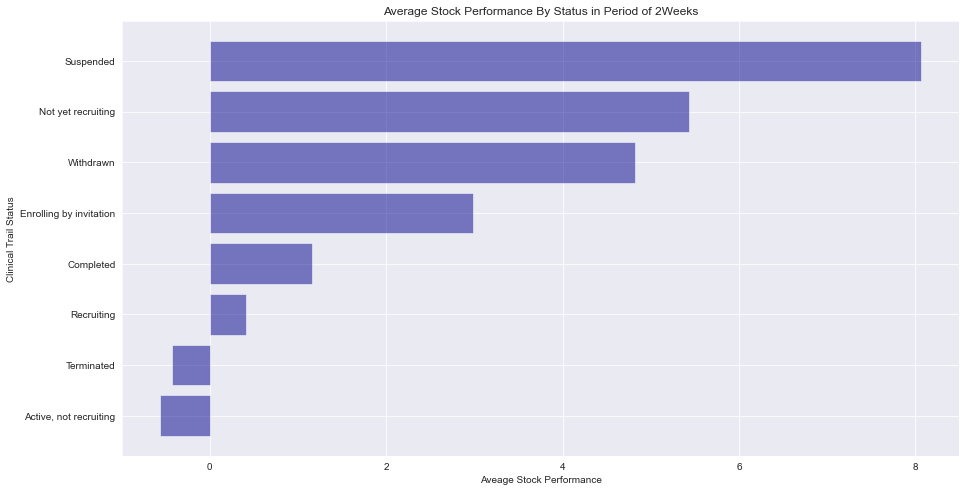

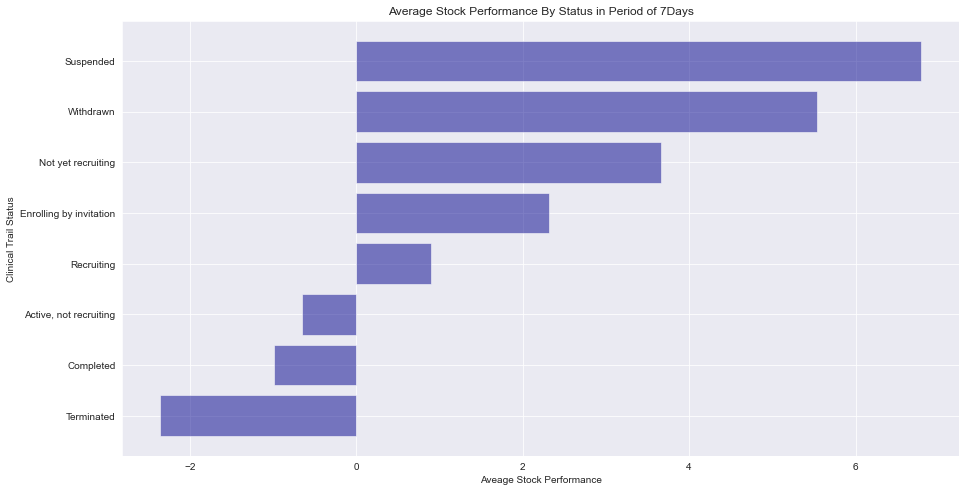

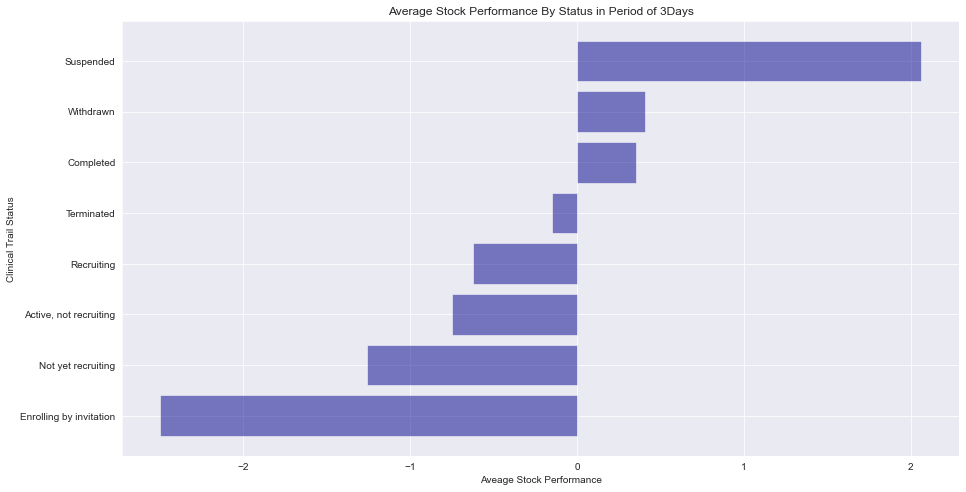

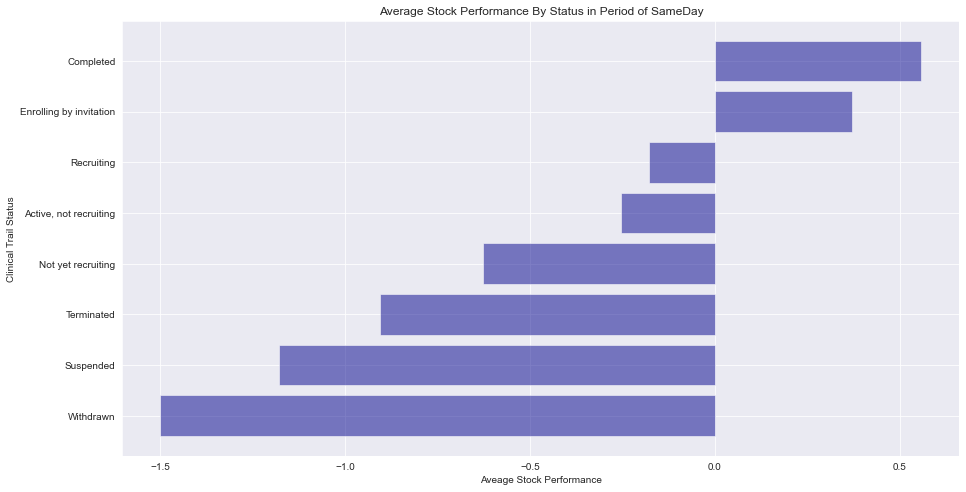

In [156]:
def averageBarChart(df, period):

    column = 'performance' + period
    #avgdf = df.groupby('status').mean('performance').sort_values('performance')
    avgdf = df.groupby('status').mean(column).sort_values(column)    

    plt.gcf().set_size_inches(15, 8)    
    plt.title("Average Stock Performance By Status in Period of " + period)
    #plt.barh(avgdf.index, avgdf["performance"], label="Average Performance", color="blue", alpha=0.5)
    plt.barh(avgdf.index, avgdf[column], label="Average Performance", color="darkblue", alpha=0.5)    
    plt.xlabel("Aveage Stock Performance")
    plt.ylabel("Clinical Trail Status")
    #plt.legend(loc=0, frameon=True, title="")

    plt.show()
    return

averageBarChart(q2,'2Weeks')
averageBarChart(q2,'7Days')
averageBarChart(q2,'3Days')
averageBarChart(q2,'SameDay')

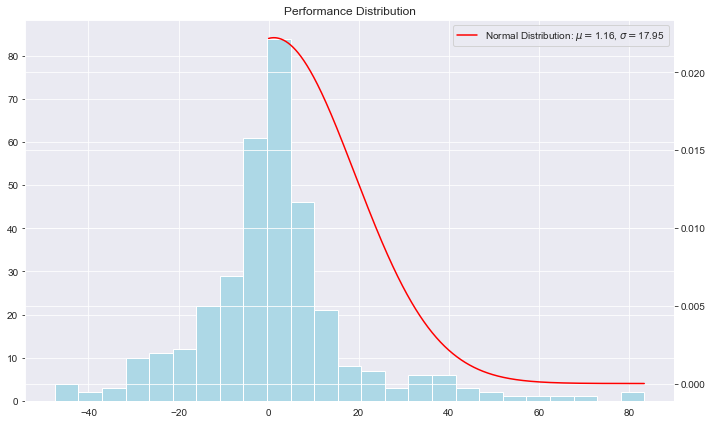

In [157]:
def histgramChart(df):
    dduration = df["performance"]
    mean, std, max = dduration.mean(), dduration.std(), dduration.max()

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.title("Performance Distribution")

    bins = 25
    ax.hist(dduration, bins, color="lightblue", label="Performance")

    # overlay a normal distribution
    ax1 = ax.twinx()
    x = np.linspace(0, max, 1000)
    y = stats.norm.pdf(x, mean, std)
    ax1.plot(x, y, color="r")
    ax1.legend(
        [
            "Normal Distribution: $\mu=$"
            + np.around(mean, 2).astype(str)
            + ", $\sigma=$"
            + np.around(std, 2).astype(str)
        ],
        loc=0,
    )

    fig.tight_layout()
    plt.show()
    return


histgramChart(q2)

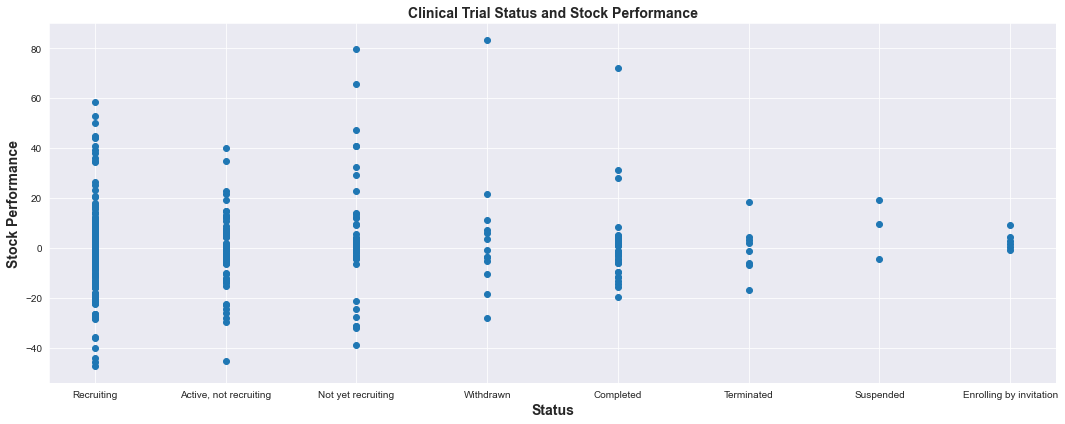

In [158]:
# visualization
def scatterChart(dx, dy):
    fig, ax = plt.subplots() 
    plt.gcf().set_size_inches(15,6)

    title = 'Clinical Trial Status and Stock Performance'
    ax.scatter(dx, dy)    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Status", fontsize=14, fontweight='bold')
    ax.set_ylabel("Stock Performance", fontsize=14, fontweight='bold')    
    #ax.set_xticklabels(data.infection_case,rotation=75,horizontalalignment='right',fontweight='light',fontsize='large')

    fig.tight_layout()
    plt.show()
    return

scatterChart(q2["status"], q2.performance)

<AxesSubplot:xlabel='performance'>

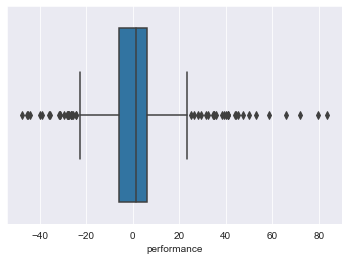

In [159]:
#visualize outliers
sns.boxplot(x=q2['performance'])

In [138]:
# remove outlier 1: z-score <-3 or >3
q2['zscore']=stats.zscore(q2['performance'])
q2['zscore']=stats.zscore(q2['performance'])
threshold1=3
threshold2=-3
q2_z = q2[(q2.zscore<threshold1) & (q2.zscore>threshold2)]
#print(q2_z.shape)

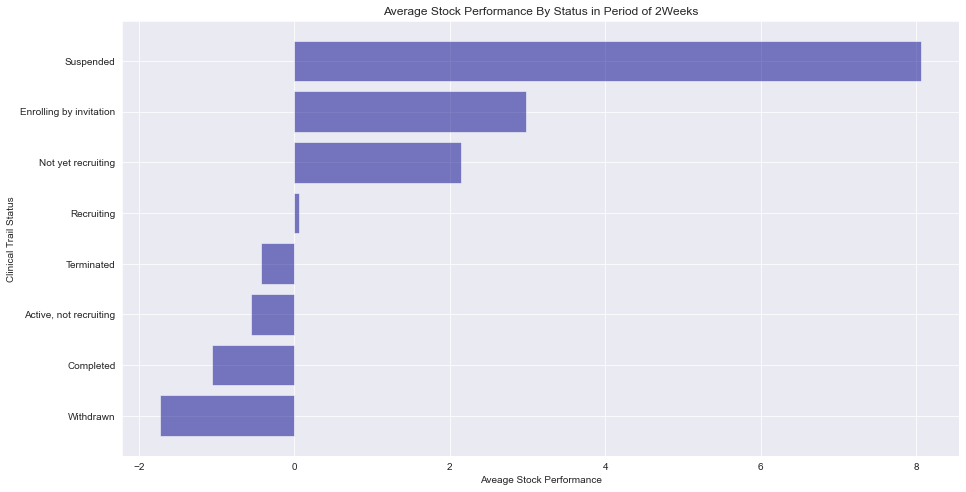

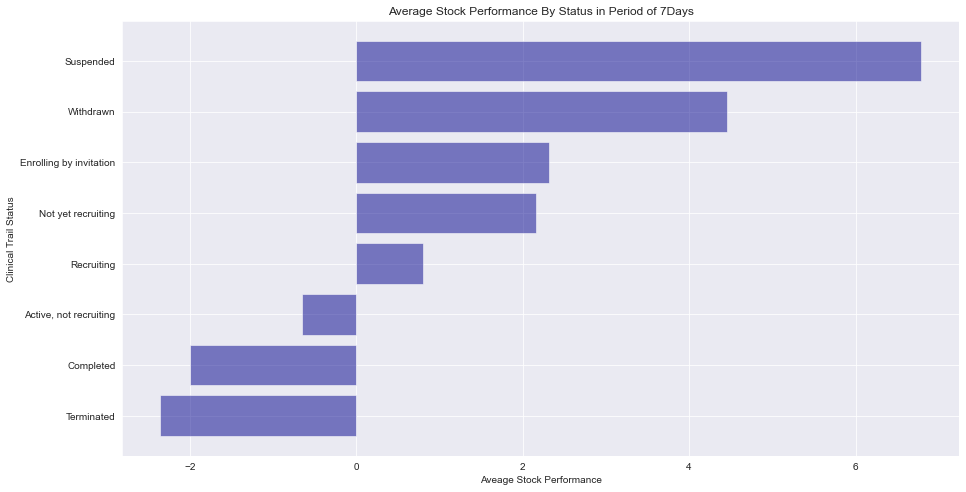

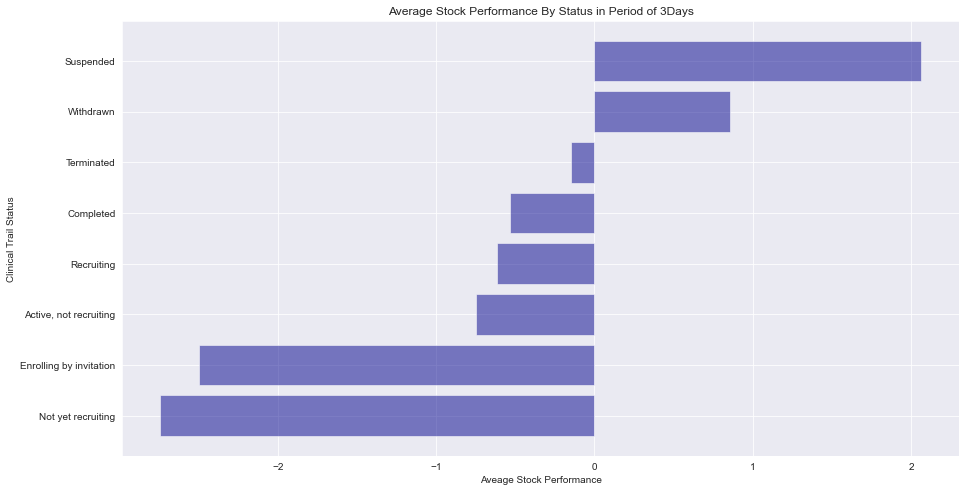

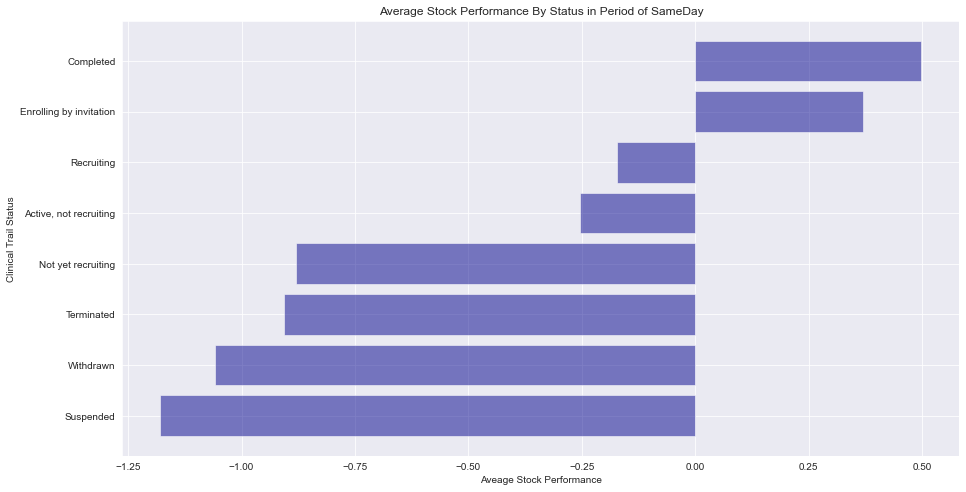

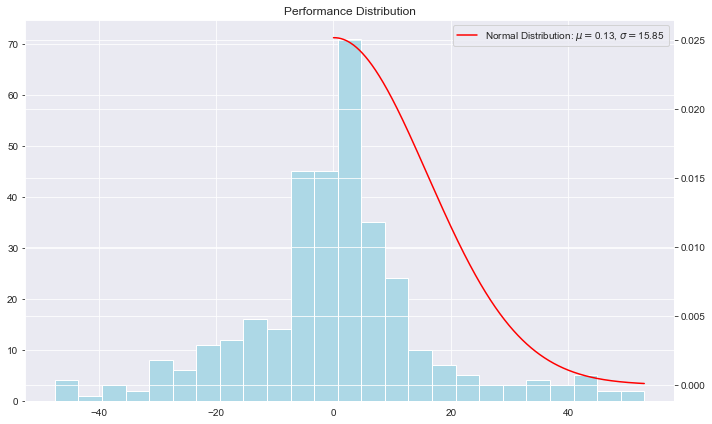

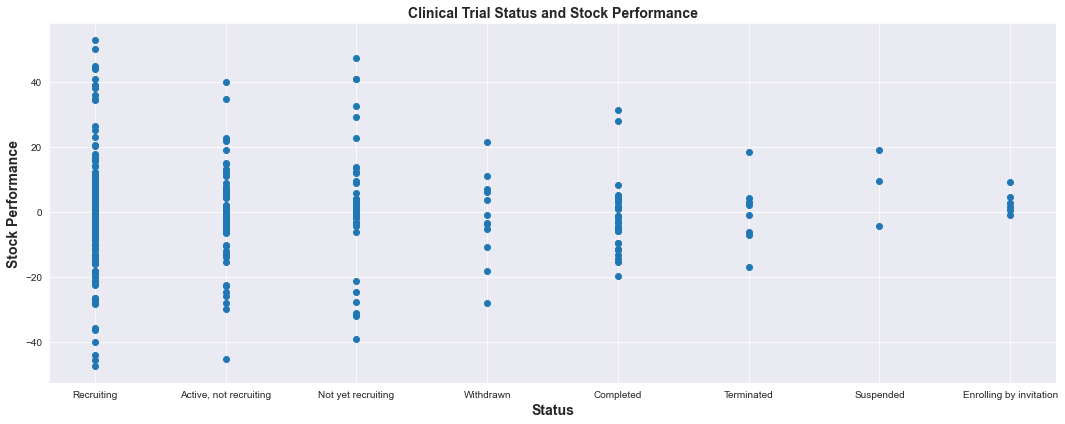

In [160]:
# chart again after removing outlier
averageBarChart(q2_z,'2Weeks')
averageBarChart(q2_z,'7Days')
averageBarChart(q2_z,'3Days')
averageBarChart(q2_z,'SameDay')
histgramChart(q2_z)
scatterChart(q2_z["status"], q2_z.performance)

In [142]:
# take a detailed look of withdrawn and suspended trails
q2[q2.status=='Withdrawn'].sort_values('performance')

,symbol,company,phases,status,last_update_posted,completion_date,why_stopped,performance2Weeks,performance7Days,performance3Days,performanceSameDay,performance,zscore
3608,SRNE,Sorrento,Phase 1|Phase 2,Withdrawn,2021-02-12,2021-04-30,Different study will be conducted,-27.889633,-5.531612,-13.469627,-3.681387,-27.889633,-1.620575
3093,CLBS,Caladrius Biosciences,Phase 1,Withdrawn,2020-12-17,2021-05-31,Acute COVID-19 treatments have improved signif...,-18.285717,-1.298700,14.728687,0.680271,-18.285717,-1.084885
2546,TAK,Takeda,Phase 1,Withdrawn,2020-10-08,2020-10-30,Business Decision (no enrollment),-10.633734,-5.059030,3.488363,1.542860,-10.633734,-0.658071
767,KPTI,Karyopharm Inc,Phase 2,Withdrawn,2020-12-07,2020-08-30,No participants enrolled,-5.333335,7.107672,10.105260,NaN,-5.333335,-0.362424
2461,XAIR,Beyond Air,Phase 2,Withdrawn,2021-01-22,2020-12-15,Terminated (halted prematurely),-3.717477,-5.118825,-1.486987,1.310856,-3.717477,-0.272294
740,INCY,Incyte,Phase 2,Withdrawn,2020-05-21,2021-12-31,Could not make FDA required changes,-3.458214,4.903500,1.522278,0.192915,-3.458214,-0.257833
2696,BMY,Bristol-Myers Squibb,Phase 1|Phase 2,Withdrawn,2020-07-20,2020-12-31,Funding,-0.838924,0.833767,0.284754,-1.376682,-0.838924,-0.111733
1734,HOPE,Hope Pharmaceuticals,Phase 2,Withdrawn,2020-09-16,2020-08-15,No recruitment,3.727856,-6.349210,-9.935896,NaN,3.727856,0.142994
2937,RDHL,RedHill Limited,Phase 1|Phase 2,Withdrawn,2020-08-11,2021-06-30,To be replaced with a randomized placebo-contr...,5.994150,7.445442,-16.254034,-6.465066,5.994150,0.269404
1923,PFE,Pfizer,Phase 2,Withdrawn,2020-07-31,2020-10-18,Due to the pursuit of other SARS-CoV-2-related...,7.172316,2.092551,0.479564,0.522459,7.172316,0.335120


In [143]:
q2[q2.status=='Suspended'].sort_values('performance')

,symbol,company,phases,status,last_update_posted,completion_date,why_stopped,performance2Weeks,performance7Days,performance3Days,performanceSameDay,performance,zscore
3259,AZN,AstraZeneca|Iqvia |Covance,Phase 3,Suspended,2021-02-11,2021-05-11,Study has been suspended due to the occurrence...,-4.345047,2.365330,3.173656,-0.496623,-4.345047,-0.307299
3259,IQV,AstraZeneca|Iqvia |Covance,Phase 3,Suspended,2021-02-11,2021-05-11,Study has been suspended due to the occurrence...,9.440719,2.372386,2.768444,0.620892,9.440719,0.461647
1971,SNDX,Syndax Pharmaceuticals,Phase 2,Suspended,2020-08-11,2020-11-15,"Given enrollment challenges, partly attributab...",19.105118,15.637865,0.253325,-3.660133,19.105118,1.000710


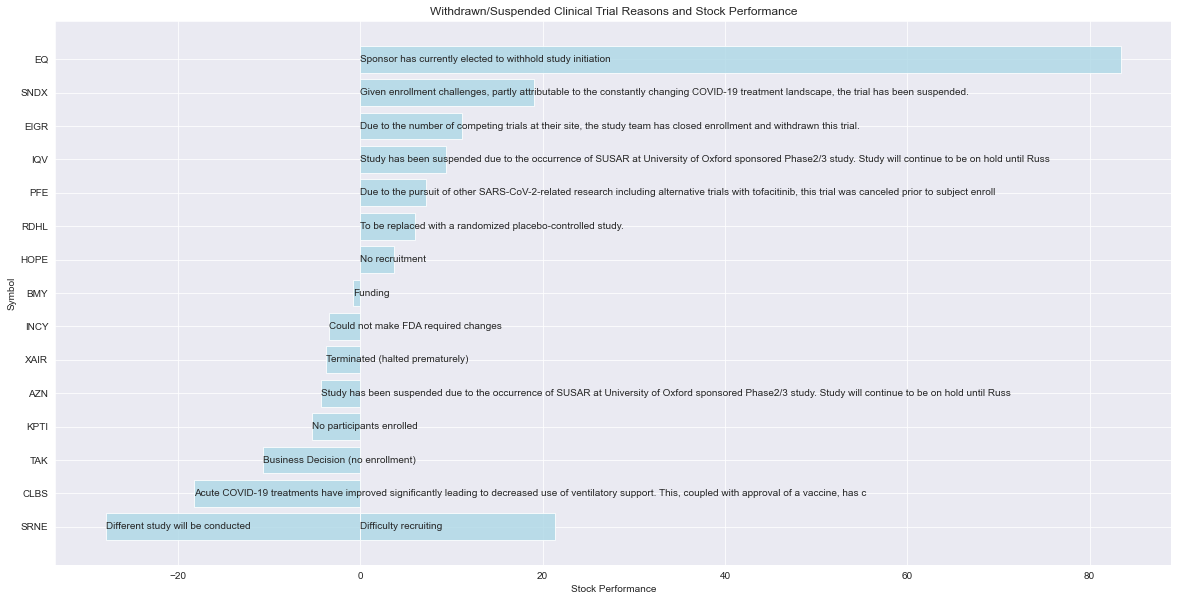

In [164]:
# explore withdrawn trails stopped reason
#q2why = q2[q2.status=='Withdrawn'].sort_values('performance')
#q2why = q2[q2.status=='Suspended'].sort_values('performance')
q2why = q2[(q2.status=='Withdrawn')|(q2.status=='Suspended')].sort_values('performance')
bar_label = q2why.why_stopped.tolist()

def autolabel(ax, bar_plot):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        width = rect.get_width()        
        if (width < 0):
            xstart = width
        else:
            xstart = 0
        ax.text(xstart, rect.get_y() + height/2,
                bar_label[idx][:150],
                ha='left', va='center')

def stopReasonBarChart(df):    
    fig, ax = plt.subplots() 
    plt.gcf().set_size_inches(20,10)

    bar_plot = plt.barh(df.symbol, df.performance, label="perrformance", color="lightblue", alpha=0.8)
    #plt.yticks([], []) #remove y ticks
    autolabel(ax, bar_plot)

    plt.xlabel("Stock Performance")
    plt.ylabel("Symbol")   
    plt.title('Withdrawn/Suspended Clinical Trial Reasons and Stock Performance')
    plt.show()
    
stopReasonBarChart(q2why)


No handles with labels found to put in legend.


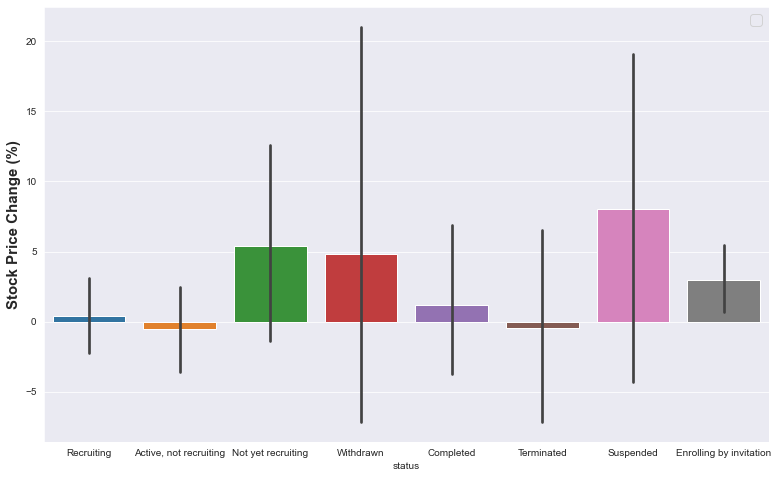

In [151]:
# just testing, ignore

fig, ax=plt.subplots(1, figsize=(13,8))
sns.color_palette('Blues')
sns.set_style('darkgrid')
sns.barplot(x=q2['status'], y=q2['performance'], data=q2, ax=ax)
#ax.set_xlabel('Phases', fontdict={'fontsize': 15, 'weight':'bold'})
ax.set_ylabel('Stock Price Change (%)', fontdict={'fontsize': 15, 'weight':'bold'})
#ax.set_title('Treatment Types in Each Phases and its contribution to Stock Price Change', fontdict={'fontsize': 20, 'weight':'bold'})
#ax.set_xticklabels(['1','1|2','2','2|3','3', '4'], fontsize=13)
plt.legend(fontsize='x-large', loc=1)